## Setting up environment with initial parameters

In [1]:
import os
import sys
import random
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tabulate import tabulate

In [2]:
# Project path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [3]:
# Output path
output_dir = os.path.join(project_root, 'outputs')
os.makedirs(output_dir, exist_ok=True)

In [4]:
def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# Set random seed for reproducibility
set_seed(123)

In [6]:
# Selected processing unit
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Constants for confusion matrix analysis
n = 30
k = 8
cm_file_path = os.path.join(output_dir, "confusion_matrix.parquet")

## Loading confusion matrix combinations from file

In [8]:
def load_parquet_confusion_matrix(file_path):
    return pd.read_parquet(file_path, engine='pyarrow')

In [9]:
# Load confusion matrix combinations from a Parquet file
df = load_parquet_confusion_matrix(cm_file_path)

print(f"Shape of DataFrame: {df.shape}")
print(df.head())

Shape of DataFrame: (10295472, 8)
   0  1  2  3  4  5  6   7
0  0  0  0  0  0  0  0  30
1  0  0  0  0  0  0  1  29
2  0  0  0  0  0  0  2  28
3  0  0  0  0  0  0  3  27
4  0  0  0  0  0  0  4  26


## Functions for fairness calculations

In [10]:
# Calculating number of confusion matrix combinations from formula 
def calculate_num_of_cm_combinations():
    C = [n + k - 1, k - 1]
    num_combinations = math.factorial(C[0]) / (math.factorial(C[1]) * math.factorial(C[0] - C[1]))
    return int(num_combinations)

In [11]:
def calculate_accuracy(df):
    return abs((df[0] + df[3] + df[4] + df[7]) / (df[0] + df[1] + df[2] + df[3] + df[4] + df[5] + df[6] + df[7]))

In [12]:
def calculate_precission(df):
    return abs((df[0] + df[4]) / (df[0] + df[2] + df[4] + df[6]))

In [13]:
def calculate_recall(df):
    return abs((df[0] + df[4]) / (df[0] + df[1] + df[4] + df[5]))

In [14]:
def calculate_accuracy_equality(df):
    return abs(((df[0] + df[3]) / (df[0] + df[1] + df[2] + df[3])) - ((df[4] + df[7]) / (df[4] + df[5] + df[6] + df[7])))

In [15]:
def calculate_statistical_parity(df):
    return abs(((df[0] + df[2]) / (df[0] + df[1] + df[2] + df[3])) - ((df[4] + df[6]) / (df[4] + df[5] + df[6] + df[7])))

In [16]:
def calculate_equal_opportunity(df):
    return abs((df[0] / (df[0] + df[1])) - (df[4] / (df[4] + df[5])))

In [17]:
def calculate_predictive_equality(df):
    return abs((df[2] / (df[2] + df[3])) - (df[6] / (df[6] + df[7])))

## Fairness calculations

In [18]:
# Calculate classification and fairness metrics from the confusion matrix
df['acc'] = calculate_accuracy(df)
df['pr'] = calculate_precission(df)
df['rc'] = calculate_recall(df)
df['ae'] = calculate_accuracy_equality(df)
df['sp'] = calculate_statistical_parity(df)
df['eop'] = calculate_equal_opportunity(df)
df['pe'] = calculate_predictive_equality(df)

## Heatmaps

In [19]:
# Bin size
bin_size = 0.01

# Formating X and Y axis values
custom_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Labels for plots
METRIC_LABELS = {
    'acc': 'Accuracy',
    'pr': 'Precision',
    'rc': 'Recall'
}

# Calculating bins
df['acc_bin'] = (df['acc'] / bin_size).round(0) * bin_size
df['pr_bin'] = (df['pr'] / bin_size).round(0) * bin_size
df['rc_bin'] = (df['rc'] / bin_size).round(0) * bin_size
df['sp_bin'] = (df['sp'] / bin_size).round(0) * bin_size
df['ae_bin'] = (df['ae'] / bin_size).round(0) * bin_size
df['eop_bin'] = (df['eop'] / bin_size).round(0) * bin_size
df['pe_bin'] = (df['pe'] / bin_size).round(0) * bin_size

In [20]:
def generate_heatmaps(df, main_metric, save_path):
    """Plots fairness heatmaps for a given main metric (acc, pr, rc)."""
    # Create 2D distributions between the predictive performance metric and fairness metrics
    heatmaps = {
        'Accuracy Equality': df.groupby([f'{main_metric}_bin', 'ae_bin']).size().unstack(fill_value=0) / len(df),
        'Statistical Parity': df.groupby([f'{main_metric}_bin', 'sp_bin']).size().unstack(fill_value=0) / len(df),
        'Equal Opportunity': df.groupby([f'{main_metric}_bin', 'eop_bin']).size().unstack(fill_value=0) / len(df),
        'Predictive Equality': df.groupby([f'{main_metric}_bin', 'pe_bin']).size().unstack(fill_value=0) / len(df),
    }

    fairness_keys = list(heatmaps.keys())

    fig = plt.figure(figsize=(28, 8))
    gs = gridspec.GridSpec(2, 4, height_ratios=[1, 5], hspace=0.05, wspace=0.2)

    axes_hist = [plt.subplot(gs[0, i]) for i in range(4)]  # Histograms
    axes_heat = [plt.subplot(gs[1, i]) for i in range(4)]  # Heatmaps
    cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.6])  # Colorbar axis

    for i, (ax_hist, ax_heat, title) in enumerate(zip(axes_hist, axes_heat, fairness_keys)):
        data = heatmaps[title]

        # Heatmap
        sns.heatmap(
            data,
            cmap='mako',
            ax=ax_heat,
            cbar=ax_heat is axes_heat[-1],
            cbar_ax=cbar_ax if ax_heat is axes_heat[-1] else None,
            vmax=0.003 if main_metric == 'acc' else 0.001
        )

        ax_heat.set_xlabel(METRIC_LABELS.get(main_metric, main_metric), fontsize=14)
        ax_heat.set_ylabel(title, fontsize=14)

        # Format tick labels
        xticks = [j for j, val in enumerate(data.columns) if val in custom_ticks]
        xlabels = [f"{val:.2f}" for val in data.columns if val in custom_ticks]
        yticks = [j for j, val in enumerate(data.index) if val in custom_ticks]
        ylabels = [f"{val:.2f}" for val in data.index if val in custom_ticks]

        ax_heat.set_xticks(xticks)
        ax_heat.set_xticklabels(xlabels, rotation=45, fontsize=14)
        ax_heat.set_yticks(yticks)
        ax_heat.set_yticklabels(ylabels, rotation=0, fontsize=14)
        ax_heat.invert_yaxis()

        # Histogram above heatmap
        ax_hist.bar(data.columns, data.sum(axis=0), width=bin_size, color='gray')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_xticks([])
        ax_hist.set_yticks([])
        for spine in ax_hist.spines.values():
            spine.set_visible(False)

    # Colorbar and layout
    cbar_ax.set_ylabel('Proportion of all results', fontsize=14)
    cbar_ax.tick_params(labelsize=14)
    fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.1, wspace=0.2, hspace=0.05)
    
    fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

    # Additional analysis of data distribution 
    print("Analysis of data distibution: ")
    for fairness_metric, heatmap in heatmaps.items():
        total = heatmap.values.sum()
        high_acc_total = heatmap.loc[:, heatmap.columns > 0.5].values.sum()
        percentage_high = high_acc_total / total * 100
        
        print(f"{fairness_metric}: {percentage_high:.2f}% of results have Accuracy > 0.5")

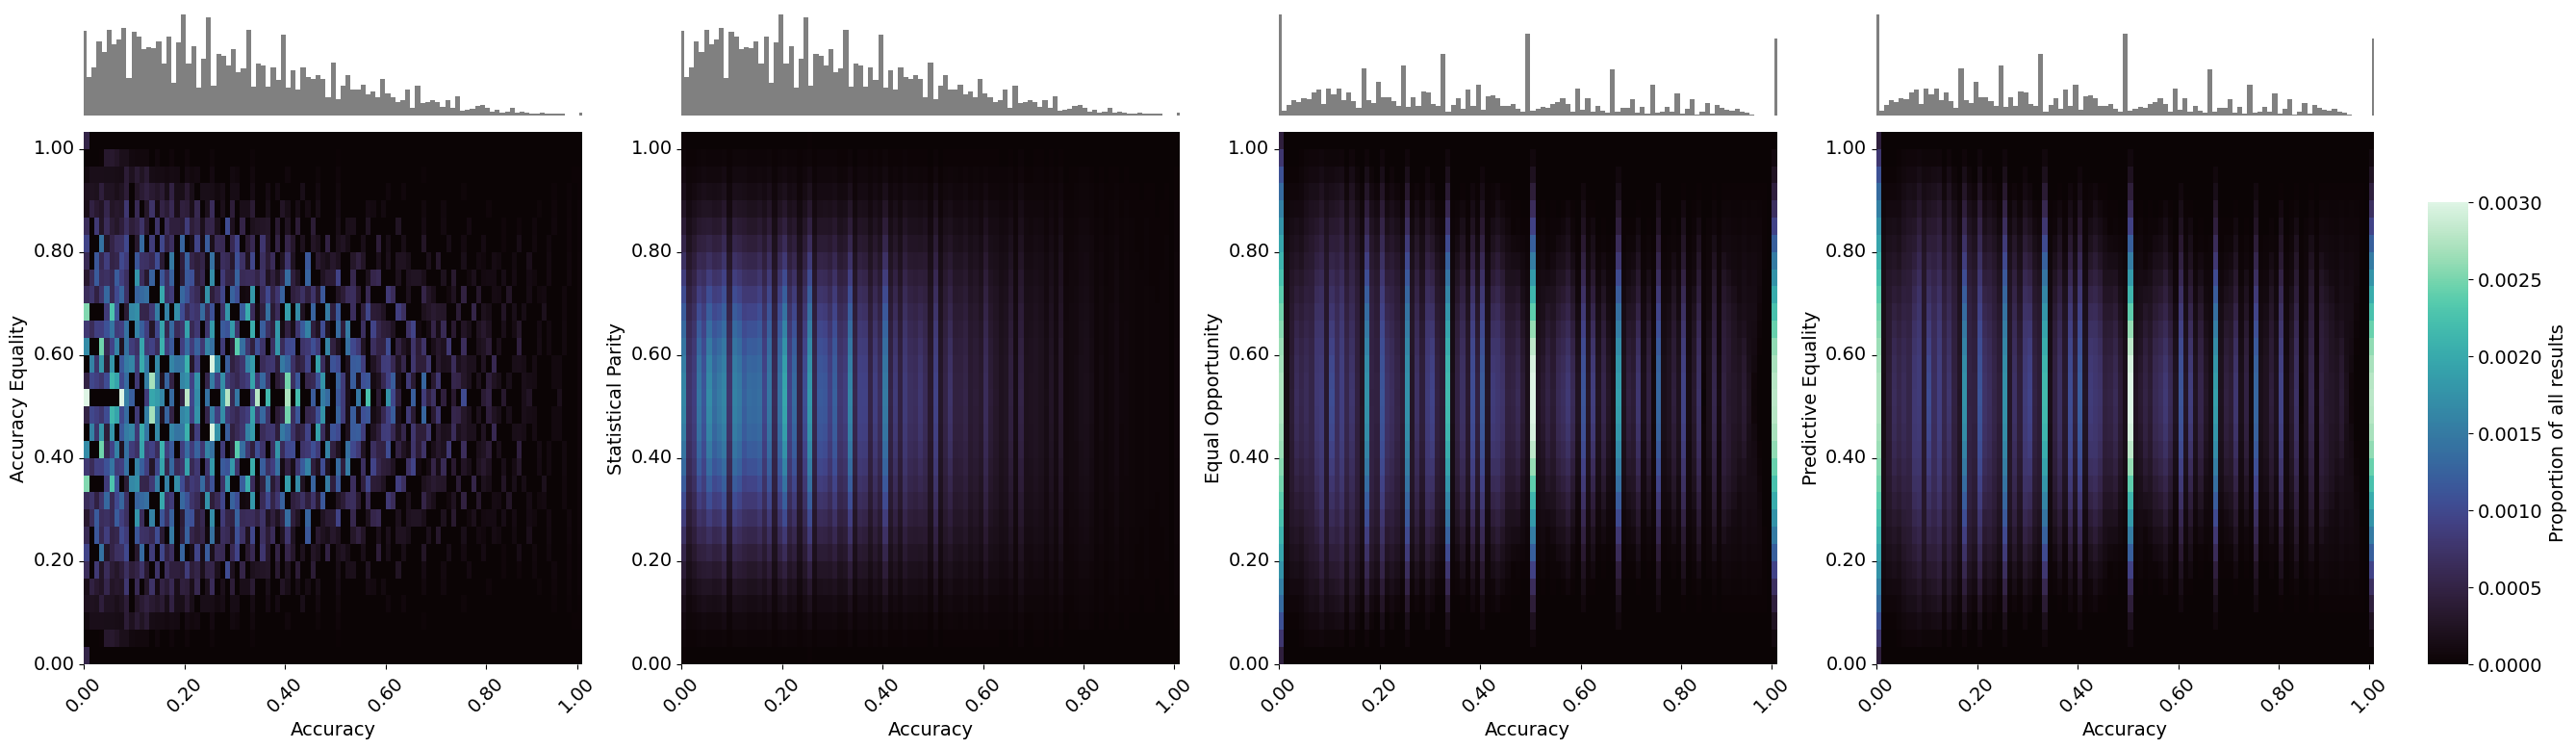

Analysis of data distibution: 
Accuracy Equality: 17.58% of results have Accuracy > 0.5
Statistical Parity: 17.58% of results have Accuracy > 0.5
Equal Opportunity: 32.06% of results have Accuracy > 0.5
Predictive Equality: 32.06% of results have Accuracy > 0.5


In [21]:
generate_heatmaps(df, 'acc', os.path.join(output_dir, "heatmaps_accuracy.png"))

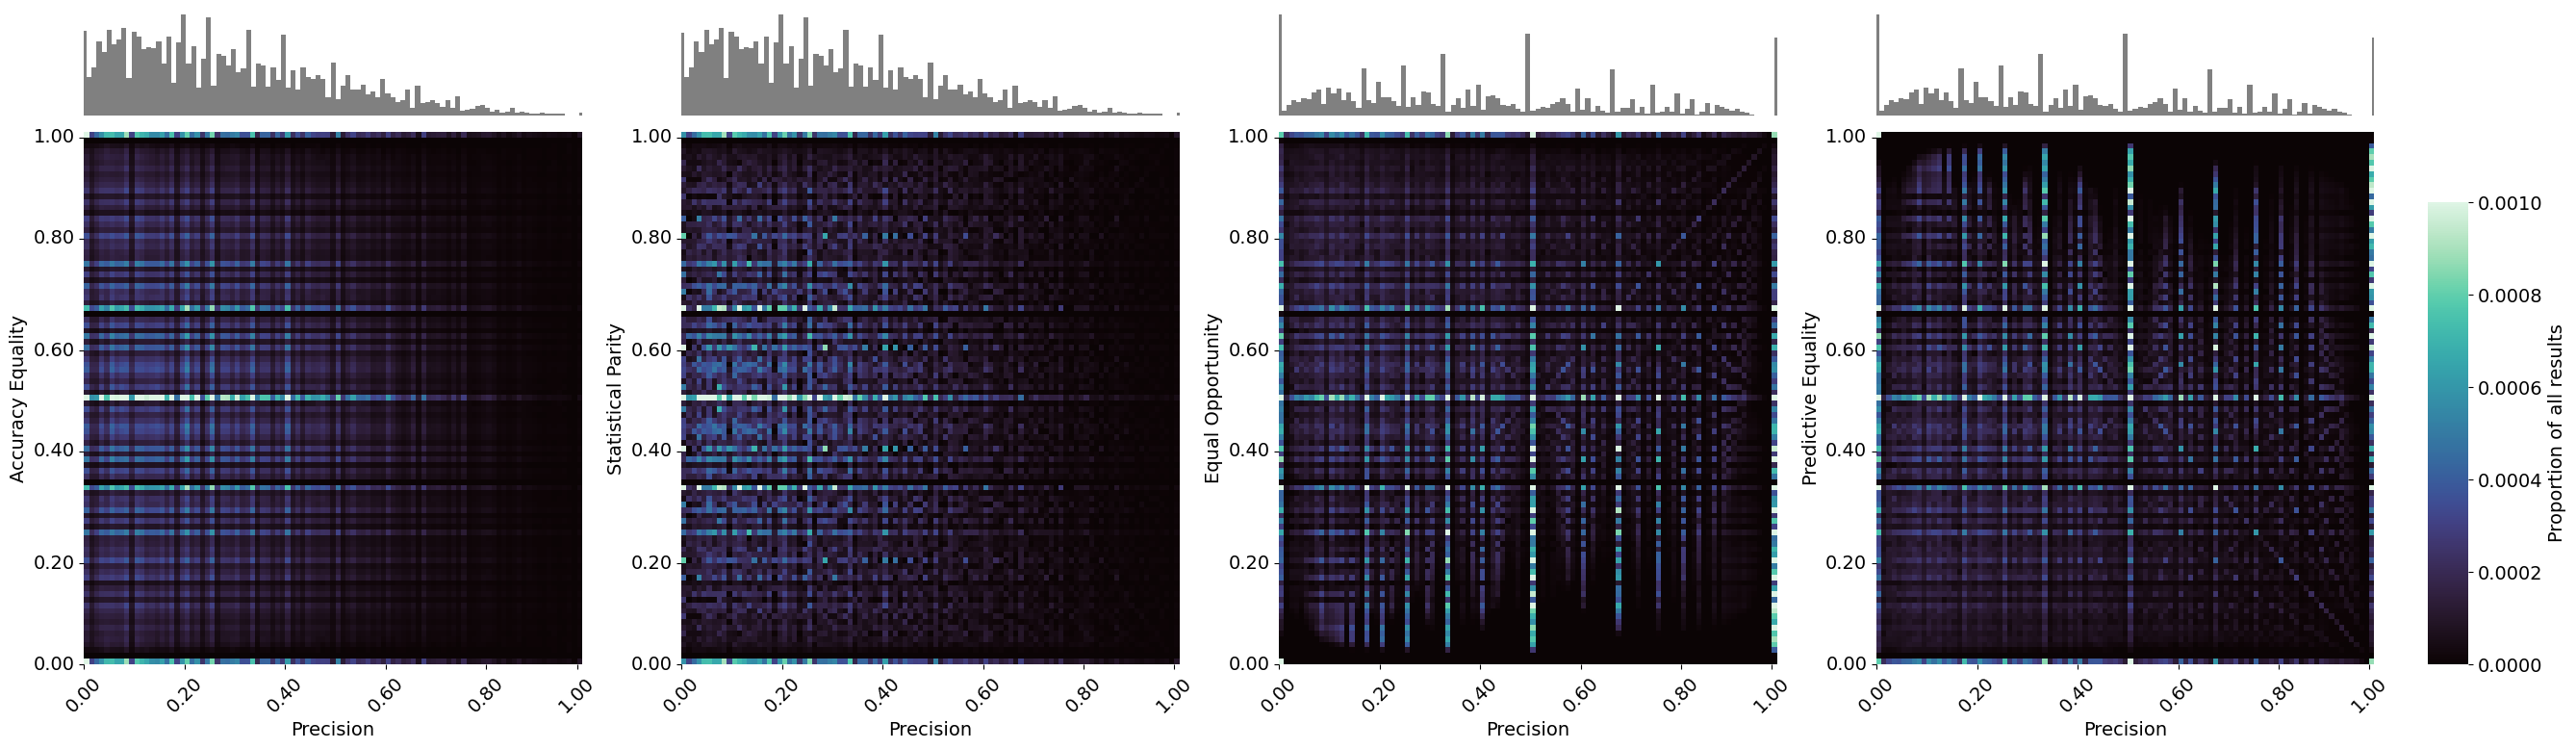

Analysis of data distibution: 
Accuracy Equality: 17.58% of results have Accuracy > 0.5
Statistical Parity: 17.59% of results have Accuracy > 0.5
Equal Opportunity: 32.08% of results have Accuracy > 0.5
Predictive Equality: 32.08% of results have Accuracy > 0.5


In [22]:
generate_heatmaps(df, 'pr', os.path.join(output_dir, "heatmaps_precision.png"))

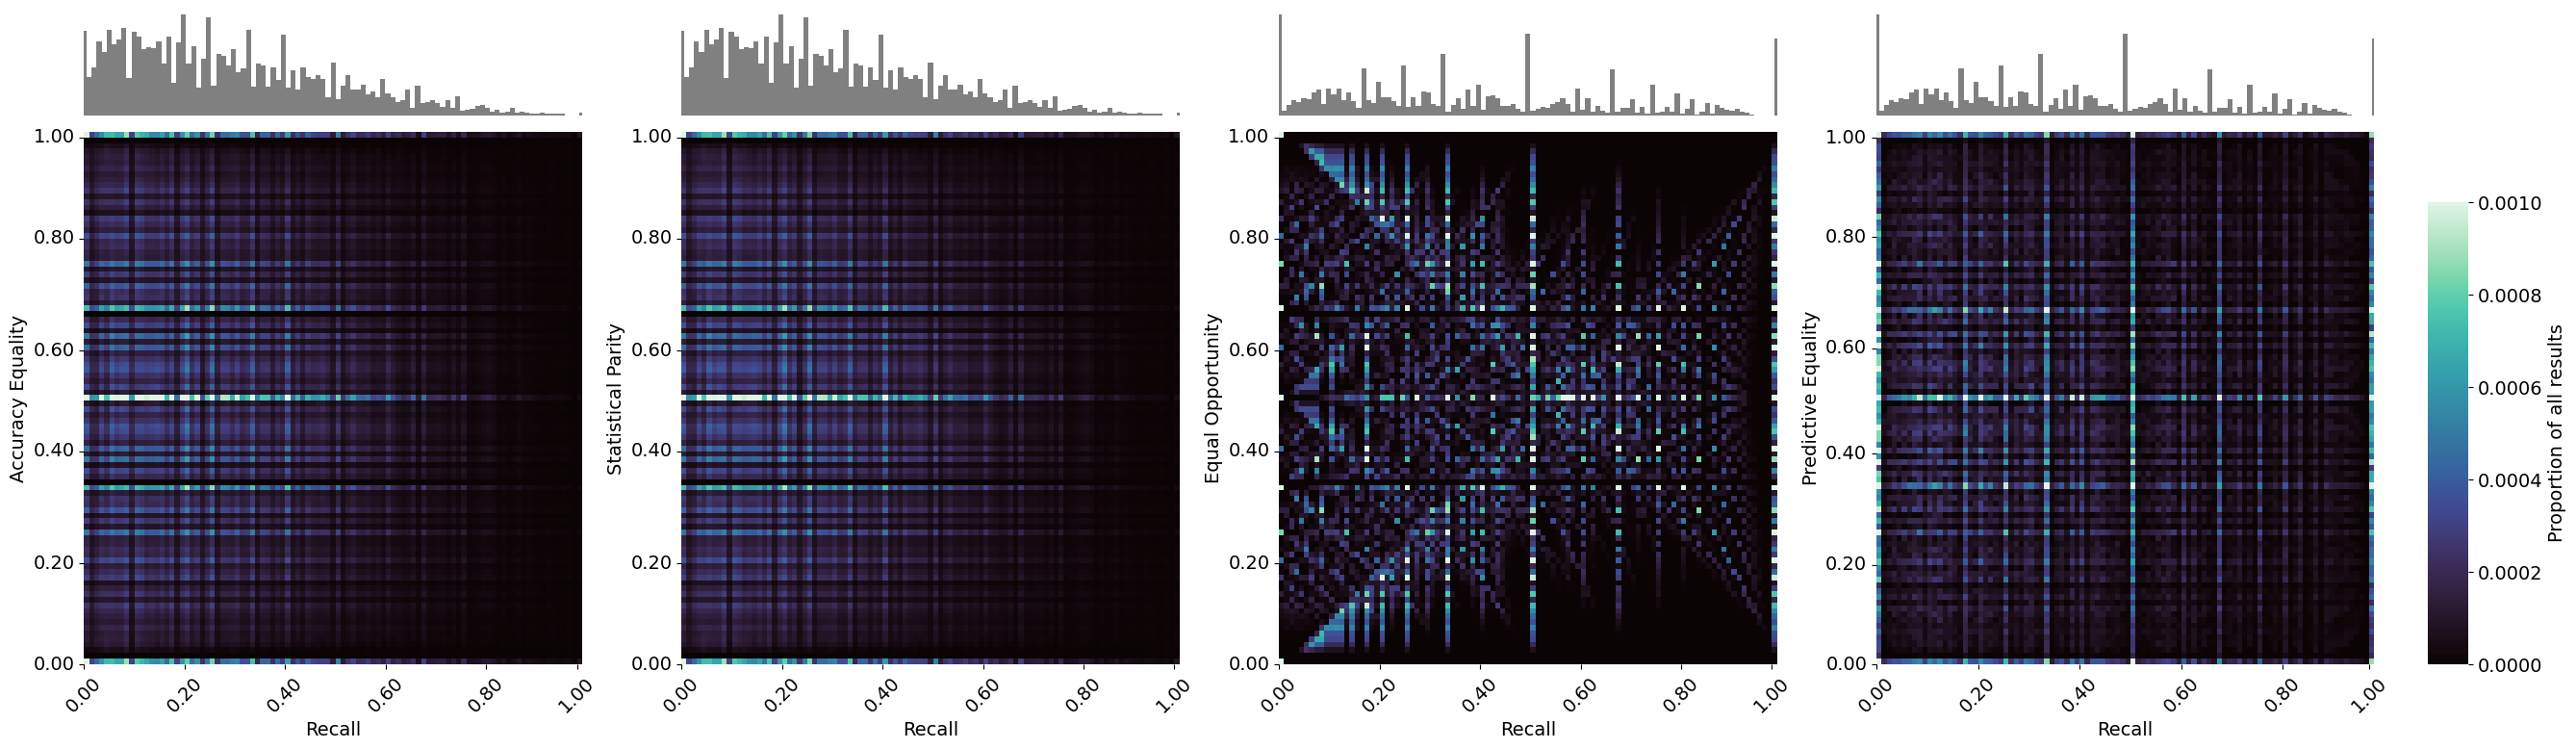

Analysis of data distibution: 
Accuracy Equality: 17.58% of results have Accuracy > 0.5
Statistical Parity: 17.58% of results have Accuracy > 0.5
Equal Opportunity: 32.06% of results have Accuracy > 0.5
Predictive Equality: 32.07% of results have Accuracy > 0.5


In [23]:
generate_heatmaps(df, 'rc', os.path.join(output_dir, "heatmaps_recall.png"))